In [1]:
%load_ext watermark
%watermark

Last updated: 2022-02-10T10:09:11.300932-03:00

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.22.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 142 Stepping 9, GenuineIntel
CPU cores   : 4
Architecture: 64bit



In [2]:
import pandas as pd

In [3]:
peliculas = pd.read_csv("movies_1.csv")

In [4]:
peliculas.head()

,presupuesto,genero,lenguaje,popularidad,productores,pais,ventas,duracion,titulo,puntuacion,n_votos
0,NaN,Comedy,en,8.387519,Sandollar Productions,United States of America,76578911.0,106.0,Father of the Bride Part II,5.7,173.0
1,NaN,Drama,en,0.894647,Miramax,South Africa,676525.0,106.0,"Cry, the Beloved Country",6.7,13.0
2,3500000.0,Comedy,en,14.569650,New Line Cinema,United States of America,28215918.0,91.0,Friday,7.0,513.0
3,NaN,Comedy,en,8.963037,Paramount Pictures,United States of America,32.0,87.0,Black Sheep,6.0,124.0
4,12000000.0,Comedy,en,9.592265,Universal Pictures,United States of America,41205099.0,92.0,Happy Gilmore,6.5,767.0


In [5]:
peliculas.genero

0       Comedy
1        Drama
2       Comedy
3       Comedy
4       Comedy
         ...  
1339    Horror
1340       NaN
1341       NaN
1342    Horror
1343       NaN
Name: genero, Length: 1344, dtype: object

## Problema a resolver
Crear un estimador k-means con un número de clusters igual al número de géneros.
Entrenar el modelo y indicar el cluster asignado a cada película.

## Entrega del trabajo
Enviar la solución en formato jupyter-notebook antes de las 13:00 pm del Martes 8 de Febrero al correo juan.mondaca@gmail.com 
Grabar el archivo ipynb con su nombre y apellido.

## Desarrollo
### Consideraciones preliminares:
- Se trabajará con un algoritmo de aprendizaje no supervisado, especificamente *K-means*.
- Como restricción, el numero de clusters debe ser igual al número de generos que hay en el dataset (sin considerar como género los valores *NaN*).
- Antes de crear el módelo, se realizará un preprocesamiento de los datos, donde se eliminarán algunas *features* y se realizarán imputaciones de acuerdo a cada caso.
- Luego, se estandarizarán los datos, ya que el algoritmo k-means se basa principalmente en el cálculo de distancias.
- Finalmente se creará y ajustará el modelo, donde se caracterizarán los clusters y se determinará a qué clúster pertence cada observación.

In [6]:
# Máquina en la que se trabajó.
%load_ext watermark
%watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2022-02-10T10:09:12.037910-03:00

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.22.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 142 Stepping 9, GenuineIntel
CPU cores   : 4
Architecture: 64bit



In [7]:
# Cargamos librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import euclidean_distances

In [8]:
# Tamaño del dataset
peliculas.shape

(1344, 11)

In [9]:
# Tipos de datos
peliculas.dtypes

presupuesto    float64
genero          object
lenguaje        object
popularidad    float64
productores     object
pais            object
ventas         float64
duracion       float64
titulo          object
puntuacion     float64
n_votos        float64
dtype: object

### Preprocesamiento

In [10]:
# Función que retorna el número y porcentaje de filas NaN del total de filas del dataset
def resumen_nul(df):
    v_nul=pd.DataFrame({'#':df.isnull().sum().sort_values(ascending = False)})
    v_nul['%']=(v_nul/df.shape[0])*100
    return v_nul

In [11]:
resumen_nul(peliculas)

,#,%
presupuesto,588,43.750000
productores,209,15.550595
ventas,141,10.491071
pais,98,7.291667
genero,51,3.794643
duracion,8,0.595238
lenguaje,0,0.000000
popularidad,0,0.000000
titulo,0,0.000000
puntuacion,0,0.000000


In [12]:
# Número de filas inicial para comparar post preprocesamiento
n_filas_inicial = peliculas.shape[0]
n_filas_inicial

1344

In [13]:
# Eliminar filas genero = NaN
peliculas_pre = peliculas.dropna(subset=['genero'])

In [14]:
# Eliminar columna presupuesto
peliculas_pre = peliculas_pre.drop(['presupuesto'], axis = 1)

Aquellas filas con pais = *NaN*, pero que tienen un valor distinto de *NaN* en productores, podrían ser llenadas, porque existen otras filas con el mismo valor en productores que sí tienen asociado un pais. De esta forma se puede deducir el pais de dicha fila.

In [15]:
# Filas que reúnen condición.
peliculas_pre[peliculas_pre['pais'].isnull() & peliculas_pre['productores'].notnull()]

,genero,lenguaje,popularidad,productores,pais,ventas,duracion,titulo,puntuacion,n_votos
61,Documentary,de,0.001223,Warren Miller Entertainment,NaN,2035470.0,96.0,Snowriders,0.0,0.0
128,Comedy,en,2.533982,Fox Searchlight Pictures,NaN,2197921.0,101.0,The Impostors,6.0,18.0
364,Comedy,en,1.200053,Imagine Entertainment,NaN,11359129.0,103.0,Opportunity Knocks,5.3,16.0
405,Drama,en,7.803563,Sony Pictures Classics,NaN,2281585.0,112.0,The Company,5.7,21.0
848,Comedy,en,1.305774,Universal Pictures,NaN,1659542.0,82.0,Out on a Limb,6.1,12.0
1062,Drama,en,0.349985,Wald/Krasna Productions,NaN,3550000.0,113.0,The Blue Veil,6.5,2.0


In [16]:
# 1. Buscar aquellas filas donde pais = NaN y productores sea distinto de NaN, y guardar los valores de productores.
# 2. Almacenar los pais para cada productor y almacenar la moda.
# 3. Almacenar en un diccionario productor ==> pais.
prods = peliculas_pre[peliculas_pre['pais'].isnull() & peliculas_pre['productores'].notnull()].productores.unique()
dic_prod_pais={}
for prod in prods:
    pais_prod = peliculas_pre[peliculas_pre['productores']==prod].pais.mode().tolist()
    if pais_prod == []:
        pass
    else:
        dic_prod_pais[prod] = pais_prod[0]

In [17]:
dic_prod_pais

{'Fox Searchlight Pictures': 'United States of America',
 'Imagine Entertainment': 'United States of America',
 'Sony Pictures Classics': 'United States of America',
 'Universal Pictures': 'United States of America'}

In [18]:
# Se imputan filas con pais = NaN y productor con país ya conocido.
for key, value in dic_prod_pais.items():
    peliculas_pre.loc[peliculas_pre['pais'].isnull() & (peliculas_pre['productores'] == key), 'pais'] = value

In [19]:
resumen_nul(peliculas_pre)

,#,%
productores,166,12.838360
ventas,112,8.662026
pais,66,5.104408
duracion,7,0.541377
genero,0,0.000000
lenguaje,0,0.000000
popularidad,0,0.000000
titulo,0,0.000000
puntuacion,0,0.000000
n_votos,0,0.000000


In [20]:
# Eliminar filas productores = NaN
peliculas_pre = peliculas_pre.dropna(subset=['productores'])

In [21]:
# Eliminar filas pais = NaN
peliculas_pre = peliculas_pre.dropna(subset=['pais'])

<ipython-input-22-929031bece85>:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  peliculas_pre[['ventas', 'duracion']].hist(ax = ax)


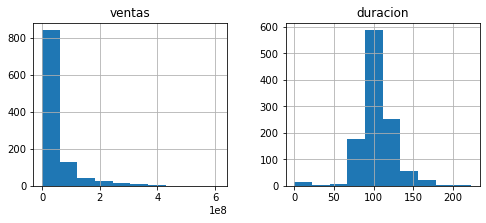

In [22]:
# Distribución variables numéricas donde hay presencia de valores NaN.
fig = plt.figure(figsize=(8,3))
ax = fig.gca()
peliculas_pre[['ventas', 'duracion']].hist(ax = ax)
plt.show()

In [23]:
# Imputación de filas con ventas = NaN por mediana.
peliculas_pre['ventas'].fillna(peliculas_pre['ventas'].median(), inplace=True)

In [24]:
# Imputación filas donde duracion = 0 por la media de aquellas filas donde duracion != 0
peliculas_pre.loc[peliculas_pre['duracion'] == 0, 'duracion'] = peliculas_pre[peliculas_pre['duracion']!=0]['duracion'].mean()

In [25]:
# Imputación de filas con duracion = NaN por media.
peliculas_pre['duracion'].fillna(peliculas_pre['duracion'].mean(), inplace=True)

<ipython-input-26-c316673a7602>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  peliculas_pre[['ventas', 'duracion']].hist(ax = ax)


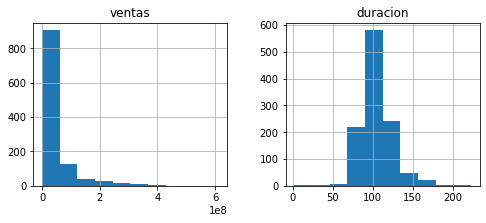

In [26]:
fig = plt.figure(figsize=(8,3))
ax = fig.gca()
peliculas_pre[['ventas', 'duracion']].hist(ax = ax)
plt.show()

In [27]:
# Resetear indices
peliculas_pre.reset_index(inplace=True, drop=True)

In [28]:
# Obtener valores de genero y categorias de genero
generos_peliculas = peliculas_pre['genero']
generos_cat = generos_peliculas.unique().tolist()
generos_cat

['Comedy',
 'Drama',
 'Documentary',
 'Science Fiction',
 'Thriller',
 'Animation',
 'Adventure',
 'Horror',
 'Fantasy',
 'War',
 'Western',
 'Music',
 'Romance',
 'Action',
 'Mystery',
 'Crime',
 'Family']

In [29]:
# Datos listos para ser trabajados
resumen_nul(peliculas_pre)

,#,%
genero,0,0.0
lenguaje,0,0.0
popularidad,0,0.0
productores,0,0.0
pais,0,0.0
ventas,0,0.0
duracion,0,0.0
titulo,0,0.0
puntuacion,0,0.0
n_votos,0,0.0


In [30]:
# Número de filas final
n_filas_final = peliculas_pre.shape[0]
n_filas_final

1125

In [31]:
# Reducción del número de filas al finalizar preprocesamiento
print('El número de filas post preprocesamiento se redujo en un {:.2%}'.format((n_filas_inicial-n_filas_final)/n_filas_inicial))

El número de filas post preprocesamiento se redujo en un 16.29%


In [32]:
peliculas_pre.head()

,genero,lenguaje,popularidad,productores,pais,ventas,duracion,titulo,puntuacion,n_votos
0,Comedy,en,8.387519,Sandollar Productions,United States of America,76578911.0,106.0,Father of the Bride Part II,5.7,173.0
1,Drama,en,0.894647,Miramax,South Africa,676525.0,106.0,"Cry, the Beloved Country",6.7,13.0
2,Comedy,en,14.569650,New Line Cinema,United States of America,28215918.0,91.0,Friday,7.0,513.0
3,Comedy,en,8.963037,Paramount Pictures,United States of America,32.0,87.0,Black Sheep,6.0,124.0
4,Comedy,en,9.592265,Universal Pictures,United States of America,41205099.0,92.0,Happy Gilmore,6.5,767.0


### Normalización y codificación

In [33]:
# Features numéricas del DataFrame
peliculas_numericos = peliculas_pre.select_dtypes(['float64'])
peliculas_numericos.head()

,popularidad,ventas,duracion,puntuacion,n_votos
0,8.387519,76578911.0,106.0,5.7,173.0
1,0.894647,676525.0,106.0,6.7,13.0
2,14.569650,28215918.0,91.0,7.0,513.0
3,8.963037,32.0,87.0,6.0,124.0
4,9.592265,41205099.0,92.0,6.5,767.0


In [34]:
# Eliminar columna título y se obtienen features categóricas del DataFrame.
# Feature título es categórica, pero única para cada observación, por lo que no sirve para clasificar.
peliculas_categoricos = peliculas_pre.drop(['titulo'], axis = 1).select_dtypes([object])
peliculas_categoricos.head()

,genero,lenguaje,productores,pais
0,Comedy,en,Sandollar Productions,United States of America
1,Drama,en,Miramax,South Africa
2,Comedy,en,New Line Cinema,United States of America
3,Comedy,en,Paramount Pictures,United States of America
4,Comedy,en,Universal Pictures,United States of America


C:\Users\pesca\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:61: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


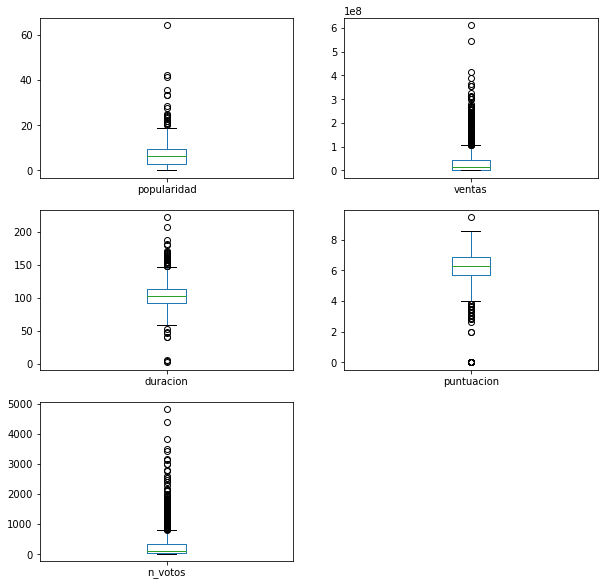

In [35]:
# Diagrama de cajas para variables numéricas
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
peliculas_numericos.plot(ax = ax, kind = 'box', subplots = True, layout = (3, 2))
plt.show()

In [36]:
# Estándarización de los datos numéricos.
# Se elige RobustScaler por sobre MinMaxScaler y StandardScaler debido a la presencia de outliers.
escalador = RobustScaler()
peliculas_numericos_norm = escalador.fit_transform(peliculas_numericos)
peliculas_numericos_norm = pd.DataFrame(peliculas_numericos_norm, columns=peliculas_numericos.columns)
peliculas_numericos_norm.head()

,popularidad,ventas,duracion,puntuacion,n_votos
0,0.317916,1.497779,0.181818,-0.500000,0.231746
1,-0.809946,-0.293131,0.181818,0.333333,-0.276190
2,1.248479,0.356659,-0.500000,0.583333,1.311111
3,0.404545,-0.309093,-0.681818,-0.250000,0.076190
4,0.499260,0.663137,-0.454545,0.166667,2.117460


In [37]:
# Codificar features categóricas
peliculas_categoricos_cod = pd.get_dummies(peliculas_categoricos)
peliculas_categoricos_cod.head()

,genero_Action,genero_Adventure,genero_Animation,genero_Comedy,genero_Crime,genero_Documentary,genero_Drama,genero_Family,genero_Fantasy,genero_Horror,...,pais_South Africa,pais_South Korea,pais_Spain,pais_Sri Lanka,pais_Sweden,pais_Taiwan,pais_Thailand,pais_Turkey,pais_United Kingdom,pais_United States of America
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [38]:
# Concatenar ambos DataFrames
peliculas_proc = pd.concat([peliculas_numericos_norm, peliculas_categoricos_cod], axis = 1)
peliculas_proc.head()

,popularidad,ventas,duracion,puntuacion,n_votos,genero_Action,genero_Adventure,genero_Animation,genero_Comedy,genero_Crime,...,pais_South Africa,pais_South Korea,pais_Spain,pais_Sri Lanka,pais_Sweden,pais_Taiwan,pais_Thailand,pais_Turkey,pais_United Kingdom,pais_United States of America
0,0.317916,1.497779,0.181818,-0.500000,0.231746,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,-0.809946,-0.293131,0.181818,0.333333,-0.276190,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1.248479,0.356659,-0.500000,0.583333,1.311111,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0.404545,-0.309093,-0.681818,-0.250000,0.076190,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0.499260,0.663137,-0.454545,0.166667,2.117460,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [39]:
peliculas_proc.shape

(1125, 680)

### Modelo *k-means*

In [40]:
# Crear modelo k-means con K clusters usando algoritmo k-means++ para definir centroides aleatorios.
K = len(generos_cat)
estimador_kmedias = KMeans(n_clusters=K, init='k-means++',  random_state=42)
estimador_kmedias.fit(peliculas_proc)

KMeans(n_clusters=17, random_state=42)

In [41]:
# Clusters o labels de los clusters
lclusters = estimador_kmedias.labels_
np.unique(lclusters)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [42]:
# Centroide; cantidad de centroides = K.
centroides = estimador_kmedias.cluster_centers_
print('{} centroides con {} dimensiones.'.format(K,centroides[0].size))

17 centroides con 680 dimensiones.


In [43]:
# Distancia entre los centroides
distancias_centroides = euclidean_distances(centroides)
pd.DataFrame(distancias_centroides)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.000000,3.174933,12.345616,2.216798,5.081285,1.864031,2.231456,8.641912,1.305187,1.700037,1.266523,2.863080,1.726971,16.610834,6.779067,5.405369,5.805817
1,3.174933,0.000000,9.771220,3.300297,2.517093,2.277294,3.468775,5.767035,3.173181,3.357950,3.005860,1.814860,2.432151,15.159420,4.811144,5.940842,2.949538
2,12.345616,9.771220,0.000000,12.542065,7.501198,11.648580,12.205650,5.463866,12.301178,12.447497,12.307022,9.906447,11.473866,9.687023,6.092312,13.858472,8.277065
3,2.216798,3.300297,12.542065,0.000000,5.149186,1.645715,3.567521,8.763080,2.100481,2.267566,1.813365,3.091482,2.816800,16.929063,7.201310,3.663239,5.897846
4,5.081285,2.517093,7.501198,5.149186,0.000000,4.176381,5.358482,4.406288,5.007024,5.092860,4.978298,2.558988,4.299993,13.041945,2.746896,7.317474,3.093418
5,1.864031,2.277294,11.648580,1.645715,4.176381,0.000000,3.010878,7.940826,1.795782,1.710638,1.541963,1.939501,1.736451,15.985414,6.236153,5.087833,5.086117
6,2.231456,3.468775,12.205650,3.567521,5.358482,3.010878,0.000000,8.615861,2.563611,3.361439,2.482195,3.565268,1.951731,16.608992,6.621854,6.217325,5.895326
7,8.641912,5.767035,5.463866,8.763080,4.406288,7.940826,8.615861,0.000000,8.589176,8.722831,8.596491,6.714934,7.910737,13.787380,5.059713,10.298070,3.297548
8,1.305187,3.173181,12.301178,2.100481,5.007024,1.795782,2.563611,8.589176,0.000000,1.984369,1.900980,2.906245,2.283258,16.629026,6.842952,5.184649,5.763177
9,1.700037,3.357950,12.447497,2.267566,5.092860,1.710638,3.361439,8.722831,1.984369,0.000000,1.686777,2.851620,2.234125,16.666121,6.962549,5.801872,5.917625


In [44]:
# Resumen  clusters
resumen_clusters = pd.DataFrame(columns = peliculas_categoricos.columns.union(peliculas_numericos.columns, sort=False))
for cluster_id  in range(K):
    cluster = peliculas_pre[lclusters == cluster_id]
    arr_cat = cluster[peliculas_categoricos.columns].mode().values
    arr_num = cluster[peliculas_numericos.columns].mean().values
    arr_cat_num= np.concatenate((arr_cat[0], arr_num))
    
    data_to_append = {}
    for i in range(len(resumen_clusters.columns)):
        data_to_append[resumen_clusters.columns[i]] = arr_cat_num[i]
    resumen_clusters = resumen_clusters.append(data_to_append, ignore_index = True)

resumen_clusters = resumen_clusters.set_index(pd.Index(['cluster_'+str(i) for i in np.unique(lclusters)]))

In [45]:
resumen_clusters

,genero,lenguaje,productores,pais,popularidad,ventas,duracion,puntuacion,n_votos
cluster_0,Drama,en,BBC Films,United Kingdom,3.544104,7.242666e+06,102.425582,6.613924,59.177215
cluster_1,Comedy,en,Universal Pictures,United States of America,9.182968,1.050739e+08,111.700000,6.132500,505.650000
cluster_2,Drama,en,Legendary Pictures,United States of America,24.956052,2.838939e+08,120.166667,7.025000,3162.166667
cluster_3,Comedy,en,Paramount Pictures,United States of America,2.983923,8.853175e+06,91.844245,4.514407,47.025424
cluster_4,Comedy,en,New Line Cinema,United States of America,12.826181,1.212720e+08,103.264706,6.311765,1251.352941
cluster_5,Comedy,en,Paramount Pictures,United States of America,8.300085,2.569879e+07,98.061798,5.988202,174.550562
cluster_6,Drama,en,Tokyo Broadcasting System (TBS),India,4.063951,1.584698e+07,148.529412,6.950980,81.901961
cluster_7,Comedy,en,Imagine Entertainment,United States of America,12.654866,3.011337e+08,110.176471,6.564706,1564.764706
cluster_8,Comedy,fr,Canal+,France,3.756783,1.114557e+07,100.379765,6.237662,82.168831
cluster_9,Documentary,en,Universal Pictures,United States of America,3.004341,5.544500e+06,82.500000,7.085897,54.756410


In [46]:
# Clúster al que pertenece cada película
resultado =pd.concat([peliculas_pre['titulo'],
                      pd.DataFrame(estimador_kmedias.predict(peliculas_proc), columns=['cluster_id'])], axis=1, sort=False)

In [47]:
resultado.sample(10)

,titulo,cluster_id
709,Something from Nothing: The Art of Rap,9
1029,Lady Macbeth,0
189,The Last Picture Show,12
555,Step Brothers,4
489,The Valley of Decision,10
29,The Next Karate Kid,5
891,"Hey, Boo: Harper Lee & To Kill a Mockingbird",15
402,Rapa Nui,10
684,"For a Good Time, Call...",5
949,Standing Tall,8


In [48]:
# Número de elementos por cluster
resultado['cluster_id'].value_counts()

5     178
10    141
12    137
3     118
1      80
0      79
9      78
8      77
11     61
6      51
4      34
16     26
14     19
7      17
15     16
2      12
13      1
Name: cluster_id, dtype: int64

## Conclusiones
- El uso de *RobustScaler* por sobre *MinMaxScaler* y *StandardScaler* viene dado, porque basa el escalamiento en la mediana y por lo que no se ve afectado por la presencia de outliers.


- Se hicieron pruebas con los algoritmos de selección aleatoria de centroides *k-means++* y *random*, donde *k-means++* presentó una caracterización de clusters más adecuada a criterio personal.


- Se observa la presencia de diferentes tamaños en los clusters, es decir hay clusters con mayor representación. De acuerdo a los resultados obtenidos, los clúster 5, 10, 12 y 3 abarcan el 51% de la muestra. Una solución a esto podría ser la recopilación de más datos que hicieran la muestra más heterogena, ya que se observa una sobrerrepresentación de películas con *pais = United States of America, lenguaje = en* y *genero = Drama o Comedy*.


- El resultado del preprocesamiento redujo en un 16.29%, esto podría haberse evitado realizando imputaciones más complejas, como por ejemplo tomar aquellas filas donde *productores != NaN* y *pais != NaN*, con estos datos se podrían obtener los productores por país. Luego tomar aquellas filas donde *productores = NaN* y *pais != NaN* e imputar lo valores de productores usando la información obtenida inicialmente. En el caso de que los productores por pais fuesen más de uno, seleccionaríamos los productores en forma aleatoria, pero asignado mayor probabilidad de ocurrencia a los productores que presentan mayor frecuencia.